# **Task 2**
# **AlexNet Model**

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [4]:
BATCH_SIZE = 64
traindata = torchvision.datasets.CIFAR10(root='./data',
                              train=True,
                              download=True)

means = traindata.data.mean(axis=(0, 1, 2)) / 255
stds = traindata.data.std(axis=(0, 1, 2)) / 255

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [5]:
## transformations
## data augmentation is added in the training transformation
train_transform = transforms.Compose([
                           transforms.RandomRotation(5),  
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(32, padding=2),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means,
                                                std=stds)
                       ])

test_transform = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means,
                                                std=stds)
                       ])

## download and load training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)


## Split train data into train data and validation data
trainset, validset = torch.utils.data.random_split(trainset, [40000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, 
                                        shuffle=False, num_workers=2)

## download and load testing dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


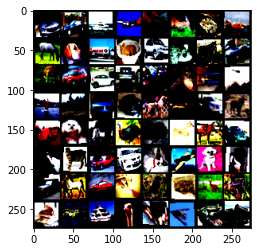

In [6]:
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.__next__()

## show images
imshow(torchvision.utils.make_grid(images))

In [24]:
# Checking the dataset
print('Training Set:\n')
for images, labels in trainloader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break


Training Set:

Image batch dimensions: torch.Size([64, 3, 32, 32])
Image label dimensions: torch.Size([64])


In [7]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2), 
            nn.BatchNorm2d(64), 
            nn.MaxPool2d(2),  
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True)
        )

        ## Dropouts are added for regularizaiton
        self.classifier = nn.Sequential(
            nn.Dropout(0.5), 
            nn.Linear(256 * 2 * 2, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x1 = x.view(x.shape[0], -1) ## Flatening the data 
        x = self.classifier(x1)
        return x

In [8]:
## Initializing the parameters in the model
def initialize_parameters(m):  
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

In [9]:
## checking the model if it is working fine
model = AlexNet()
for images, labels in trainloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([64, 3, 32, 32])
torch.Size([64, 10])


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.apply(initialize_parameters)
model = model.to(device)

In [11]:
test_acc = 0.0
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

# **Initial Accuracy**

In [12]:
test_acc = 0.0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 9.84


# **Training Model**

In [13]:
def train(model, loader, optimizer, criterion, device):
  train_running_loss = 0.0
  train_acc = 0.0

  model = model.train()

  ## training step
  for i, (images, labels) in enumerate(loader):
      
      images = images.to(device)
      labels = labels.to(device)

      ## forward + backprop + loss
      logits = model(images)
      loss = criterion(logits, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_running_loss += loss.detach().item()
      train_acc += get_accuracy(logits, labels, BATCH_SIZE)

  return train_running_loss / len(loader), train_acc / len(loader)


In [14]:
def valid(model, loader, criterion, device):
  valid_running_loss = 0.0
  valid_acc = 0.0

  model = model.eval()
  with torch.no_grad():

    for i, (images, labels) in enumerate(loader):
        
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        loss = criterion(logits, labels)

        valid_running_loss += loss.detach().item()
        valid_acc += get_accuracy(logits, labels, BATCH_SIZE)

  return valid_running_loss / len(loader), valid_acc / len(loader)


In [15]:
best_valid_loss = float('inf') # initialization
learning_rate = 0.0001
num_epochs = 50
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AlexNet()
model.apply(initialize_parameters)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

for epoch in range(num_epochs):

    # Trainig loss calculation
    train_loss, train_acc = train(model, trainloader, optimizer, criterion, device) 
    # Validation loss calculation
    valid_loss, valid_acc = valid(model, validloader, criterion, device)

    if valid_loss < best_valid_loss: ## looking for the model that gives me the best validation accuracy
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-model.pt')
    
    model.eval()
    print('Epoch: %d |' \
          %(epoch))     
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc:.2f}%')   

Epoch: 0 |
	Train Loss: 2.099 | Train Acc: 31.83%
	 Val. Loss: 1.571 |  Val. Acc: 45.96%
Epoch: 1 |
	Train Loss: 1.732 | Train Acc: 41.64%
	 Val. Loss: 1.361 |  Val. Acc: 50.95%
Epoch: 2 |
	Train Loss: 1.496 | Train Acc: 47.87%
	 Val. Loss: 1.227 |  Val. Acc: 55.55%
Epoch: 3 |
	Train Loss: 1.355 | Train Acc: 52.18%
	 Val. Loss: 1.188 |  Val. Acc: 56.87%
Epoch: 4 |
	Train Loss: 1.258 | Train Acc: 55.74%
	 Val. Loss: 1.102 |  Val. Acc: 60.57%
Epoch: 5 |
	Train Loss: 1.189 | Train Acc: 57.71%
	 Val. Loss: 1.070 |  Val. Acc: 61.68%
Epoch: 6 |
	Train Loss: 1.128 | Train Acc: 60.13%
	 Val. Loss: 1.047 |  Val. Acc: 62.44%
Epoch: 7 |
	Train Loss: 1.084 | Train Acc: 61.85%
	 Val. Loss: 0.996 |  Val. Acc: 64.21%
Epoch: 8 |
	Train Loss: 1.038 | Train Acc: 63.20%
	 Val. Loss: 0.981 |  Val. Acc: 65.15%
Epoch: 9 |
	Train Loss: 0.992 | Train Acc: 65.09%
	 Val. Loss: 0.932 |  Val. Acc: 67.41%
Epoch: 10 |
	Train Loss: 0.964 | Train Acc: 66.12%
	 Val. Loss: 0.927 |  Val. Acc: 67.30%
Epoch: 11 |
	Train L

# **Test Accuracy**

In [16]:
model.load_state_dict(torch.load('best-model.pt'))
test_acc = 0.0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 80.17
